In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# import custom modules
from data.fetch_data import DataFetcher
from data.process_data import calculate_wind_speed, calculate_skiable_days, calculate_mean_anomalies

In [10]:
location = (67.18, -50.30)
lat = location[0]
lon = location[1]
start_date = '2023-07-01'
end_date = '2023-09-10'

# fetch data
fetcher = DataFetcher(lat, lon, start_date, end_date)
tp = fetcher.fetch_hourly_variable('total_precipitation_hourly')
tp = tp * 1000  # convert to mm

# calculate daily sum
tp_daily = tp.resample('D').sum()

<AxesSubplot: xlabel='DateTime'>

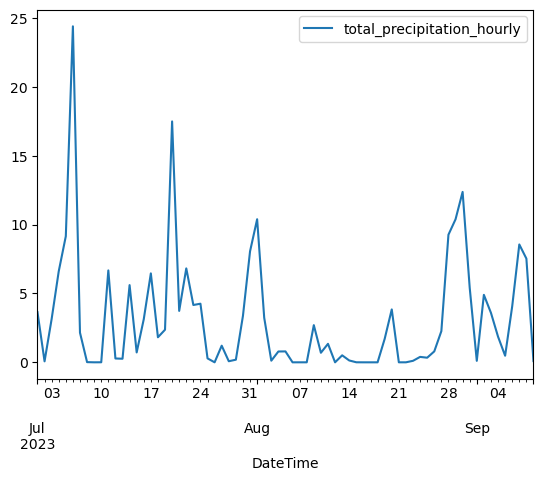

In [11]:
# plot tp
tp_daily.plot()

## Define locations and time duration

In [2]:
# Define locations and other parameters
locations = {
    "Glenshee": (56.875916, -3.377881),
    "Glencoe": (56.61286, -4.84884),
    "Cairngorm": (57.1187, -3.6542) 
}
start_date = '1950-01-01'
end_date = '2024-12-31'

## Fetch ERA5 data using google earth engine python api

In [4]:
# Fetch and process data
skiable_data = {}
winter_anomalies = {}
for name, (lat, lon) in locations.items():
    # define the data fetcher
    fetcher = DataFetcher(lat, lon, start_date, end_date)

    # fetch the data variables
    snow_depth = fetcher.fetch_daily_variable('snow_depth')
    snowfall = fetcher.fetch_daily_variable('snowfall_sum')
    u_wind = fetcher.fetch_daily_variable('u_component_of_wind_10m')
    v_wind = fetcher.fetch_daily_variable('v_component_of_wind_10m')
    wind_speed = calculate_wind_speed(u_wind['u_component_of_wind_10m'], v_wind['v_component_of_wind_10m'])
    temperature = fetcher.fetch_daily_variable('temperature_2m')

    # calculate the anomalies
    snowfall_anomalies = calculate_mean_anomalies(snowfall['snowfall_sum'], baseline_start='1950-01-01', baseline_end='1979-12-31', annual=False)
    snow_depth_amomalies = calculate_mean_anomalies(snow_depth['snow_depth'], baseline_start='1950-01-01', baseline_end='1979-12-31', annual=False)
    temperature_anomalies = calculate_mean_anomalies(temperature['temperature_2m'], baseline_start='1950-01-01', baseline_end='1979-12-31', annual=False)

    # combine anomalies and add to dictionary
    winter_anomalies[name] = {
        'snowfall': snowfall_anomalies,
        'snow_depth': snow_depth_amomalies,
        'temperature': temperature_anomalies
    }

    skiable_days = calculate_skiable_days(snow_depth['snow_depth'], wind_speed, min_snow_depth=0.25, max_wind_speed=30)
    skiable_data[name] = skiable_days


## Plot winter anomalies

Calculating anomalies for Glenshee


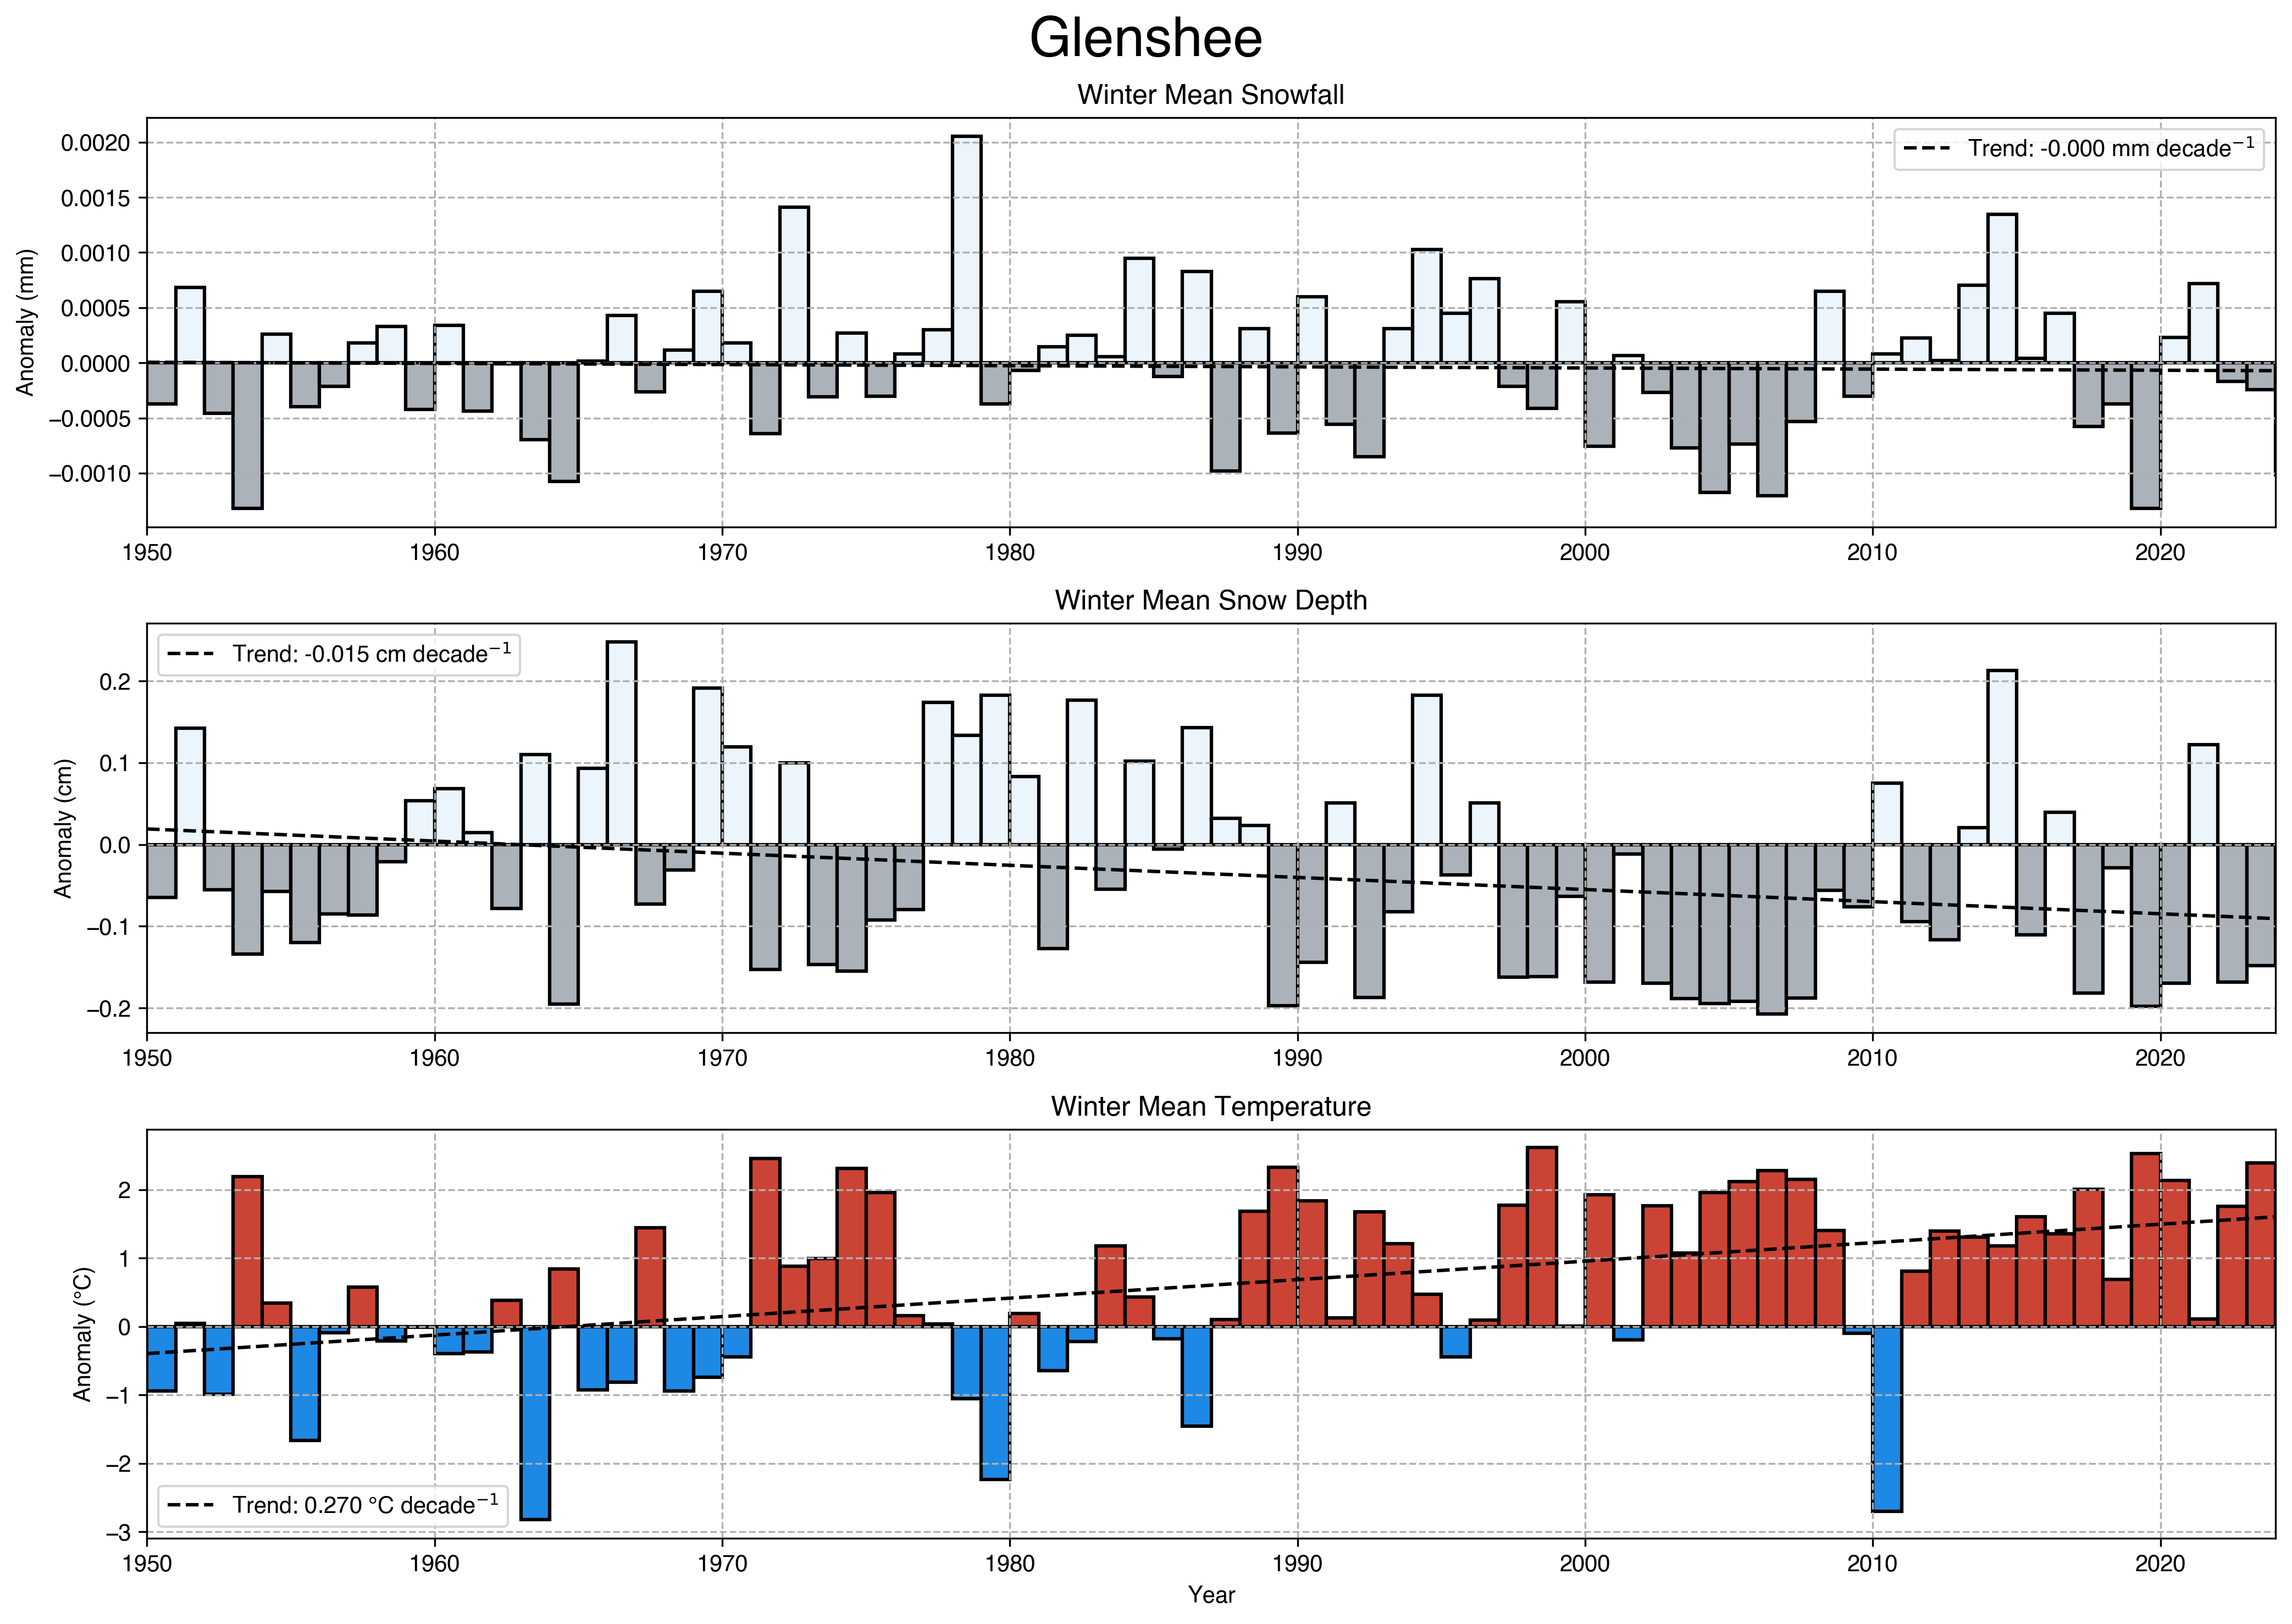

Calculating anomalies for Glencoe


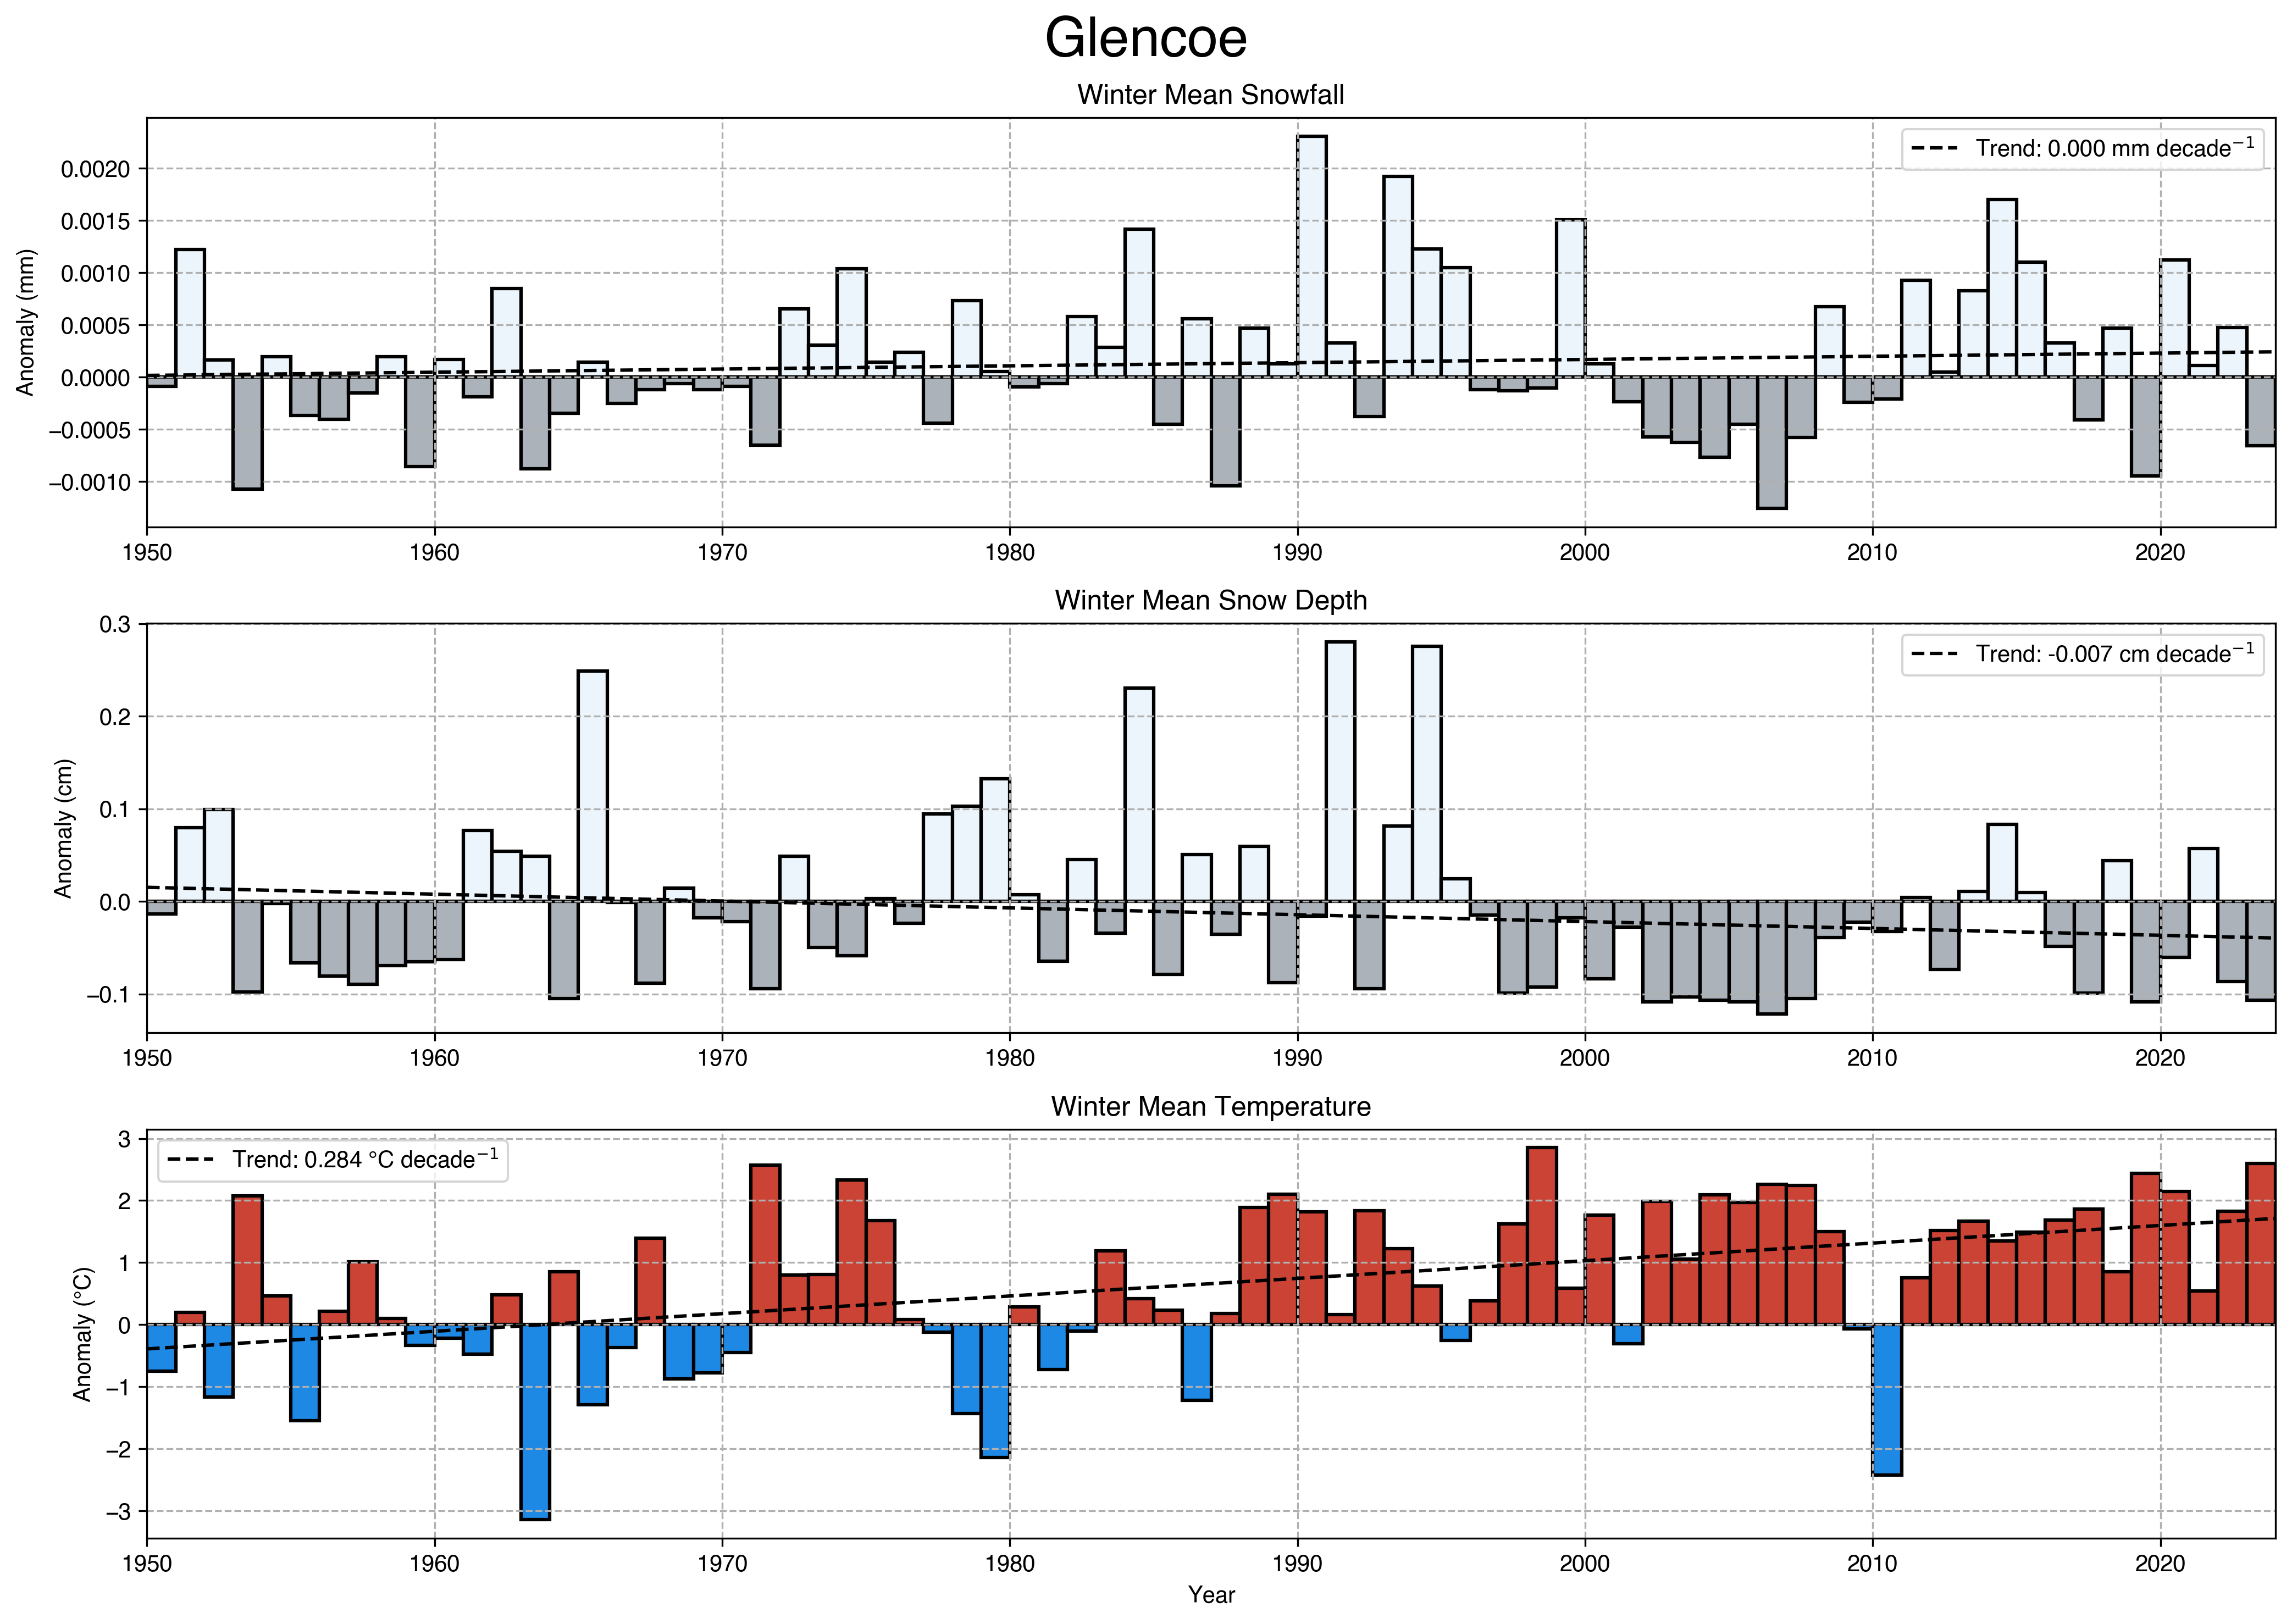

Calculating anomalies for Cairngorm


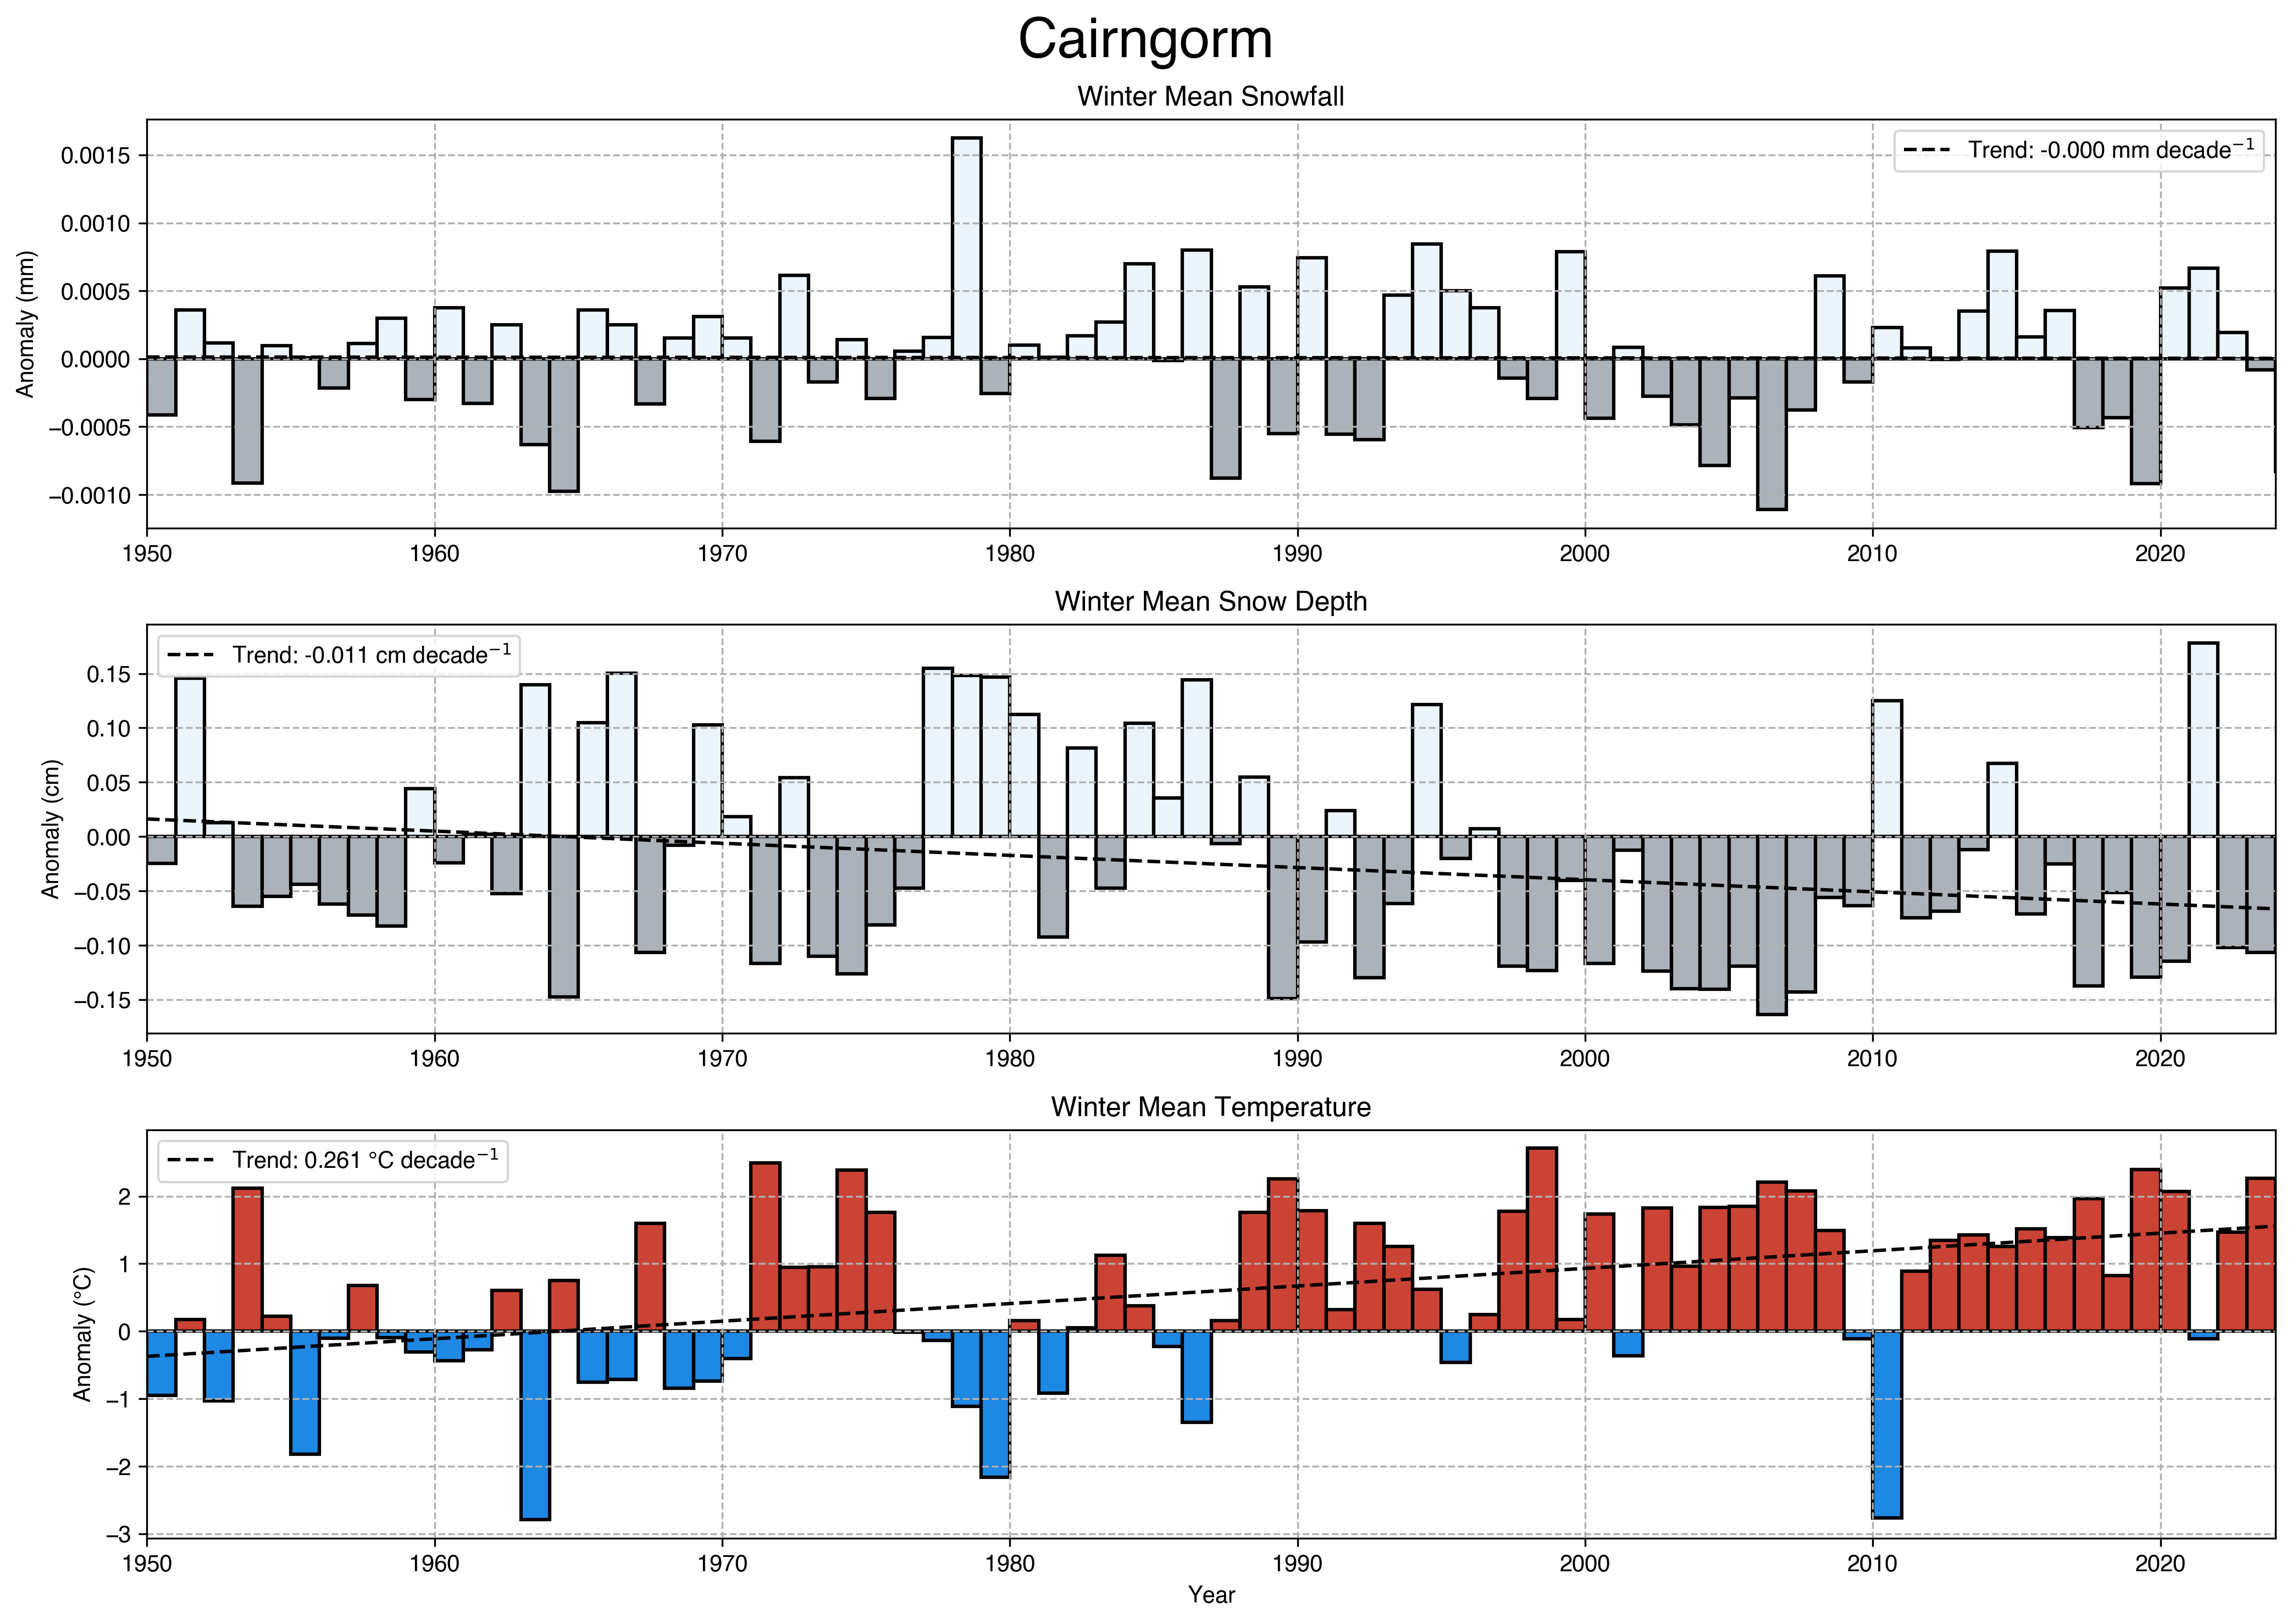

In [5]:

# Define a function to add a trend line
def add_trend_line(ax, data, color):
    # Convert datetime index to numerical values (e.g., number of years since the first date)
    x = (data.index - data.index[0]).days / 365.25
    y = data.values.flatten()
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Plot the trend line using the original datetime index for the x-axis
    # calculate decade trend and units (e.g. degrees, m ,cm) to be added to the plot
    decade_trend = slope * 10
    units = 'mm' if 'snowfall' in data.name else 'cm' if 'snow_depth' in data.name else '°C'
    ax.plot(data.index, intercept + slope * x, color=color, label=fr'Trend: {decade_trend:.3f} {units} decade$^{{-1}}$', linestyle='--')
    ax.legend()

# Function to determine bar colors based on anomaly values
def get_bar_colors(data, positive_color, negative_color):
    return [positive_color if value >= 0 else negative_color for value in data]

for location, anomalies in winter_anomalies.items():
    print('Calculating anomalies for', location)

    # Extract the anomalies for each location
    snowfall_anom = winter_anomalies[location]['snowfall']
    snow_depth_anom = winter_anomalies[location]['snow_depth']
    air_temp_anom = winter_anomalies[location]['temperature']


    plt.rcParams['font.sans-serif'] = "Helvetica"
    plt.rcParams['font.family'] = "sans-serif"
    # Plotting each variable in a subplot using bar graphs
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), dpi=300)
    bar_width = 365.0  # Set bar width to fill the entire year

    # Snowfall Anomalies Plot
    colors_snowfall = get_bar_colors(snowfall_anom, '#ebf5fb', '#abb2b9')    #           #ebf5fb  more snow,  #f39c12 
    axs[0].bar(snowfall_anom.index, snowfall_anom, color=colors_snowfall, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
    axs[0].set_title('Winter Mean Snowfall')
    axs[0].set_ylabel('Anomaly (mm)')
    axs[0].grid(True, linestyle='--')
    add_trend_line(axs[0], snowfall_anom, 'k')
    axs[0].set_xlim(snowfall_anom.index[0], snowfall_anom.index[-1])

    # Snow Depth Anomalies Plot
    colors_snow_depth = get_bar_colors(snow_depth_anom, '#ebf5fb', '#abb2b9')
    axs[1].bar(snow_depth_anom.index, snow_depth_anom, color=colors_snow_depth, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
    axs[1].set_title('Winter Mean Snow Depth')
    axs[1].set_ylabel('Anomaly (cm)')
    axs[1].grid(True, linestyle='--')
    add_trend_line(axs[1], snow_depth_anom, 'k')
    axs[1].set_xlim(snow_depth_anom.index[0], snow_depth_anom.index[-1])

    # Air Temperature Anomalies Plot
    colors_air_temp = get_bar_colors(air_temp_anom, '#cb4335', '#1e88e5')
    axs[2].bar(air_temp_anom.index, air_temp_anom, color=colors_air_temp, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
    axs[2].set_title('Winter Mean Temperature')
    axs[2].set_xlabel('Year')
    axs[2].set_ylabel('Anomaly (°C)')
    axs[2].grid(True, linestyle='--')
    add_trend_line(axs[2], air_temp_anom, 'k')
    axs[2].set_xlim(air_temp_anom.index[0], air_temp_anom.index[-1])

    # add figure title
    fig.suptitle(location, fontsize=24)

    # Save the figure
    plt.savefig(f'./output/{location}_anomalies.png')

    plt.tight_layout()
    plt.show()


## Plot skiable days for different areas

Default: snow_depth > 0.25 m, and wind speed < 30 mph

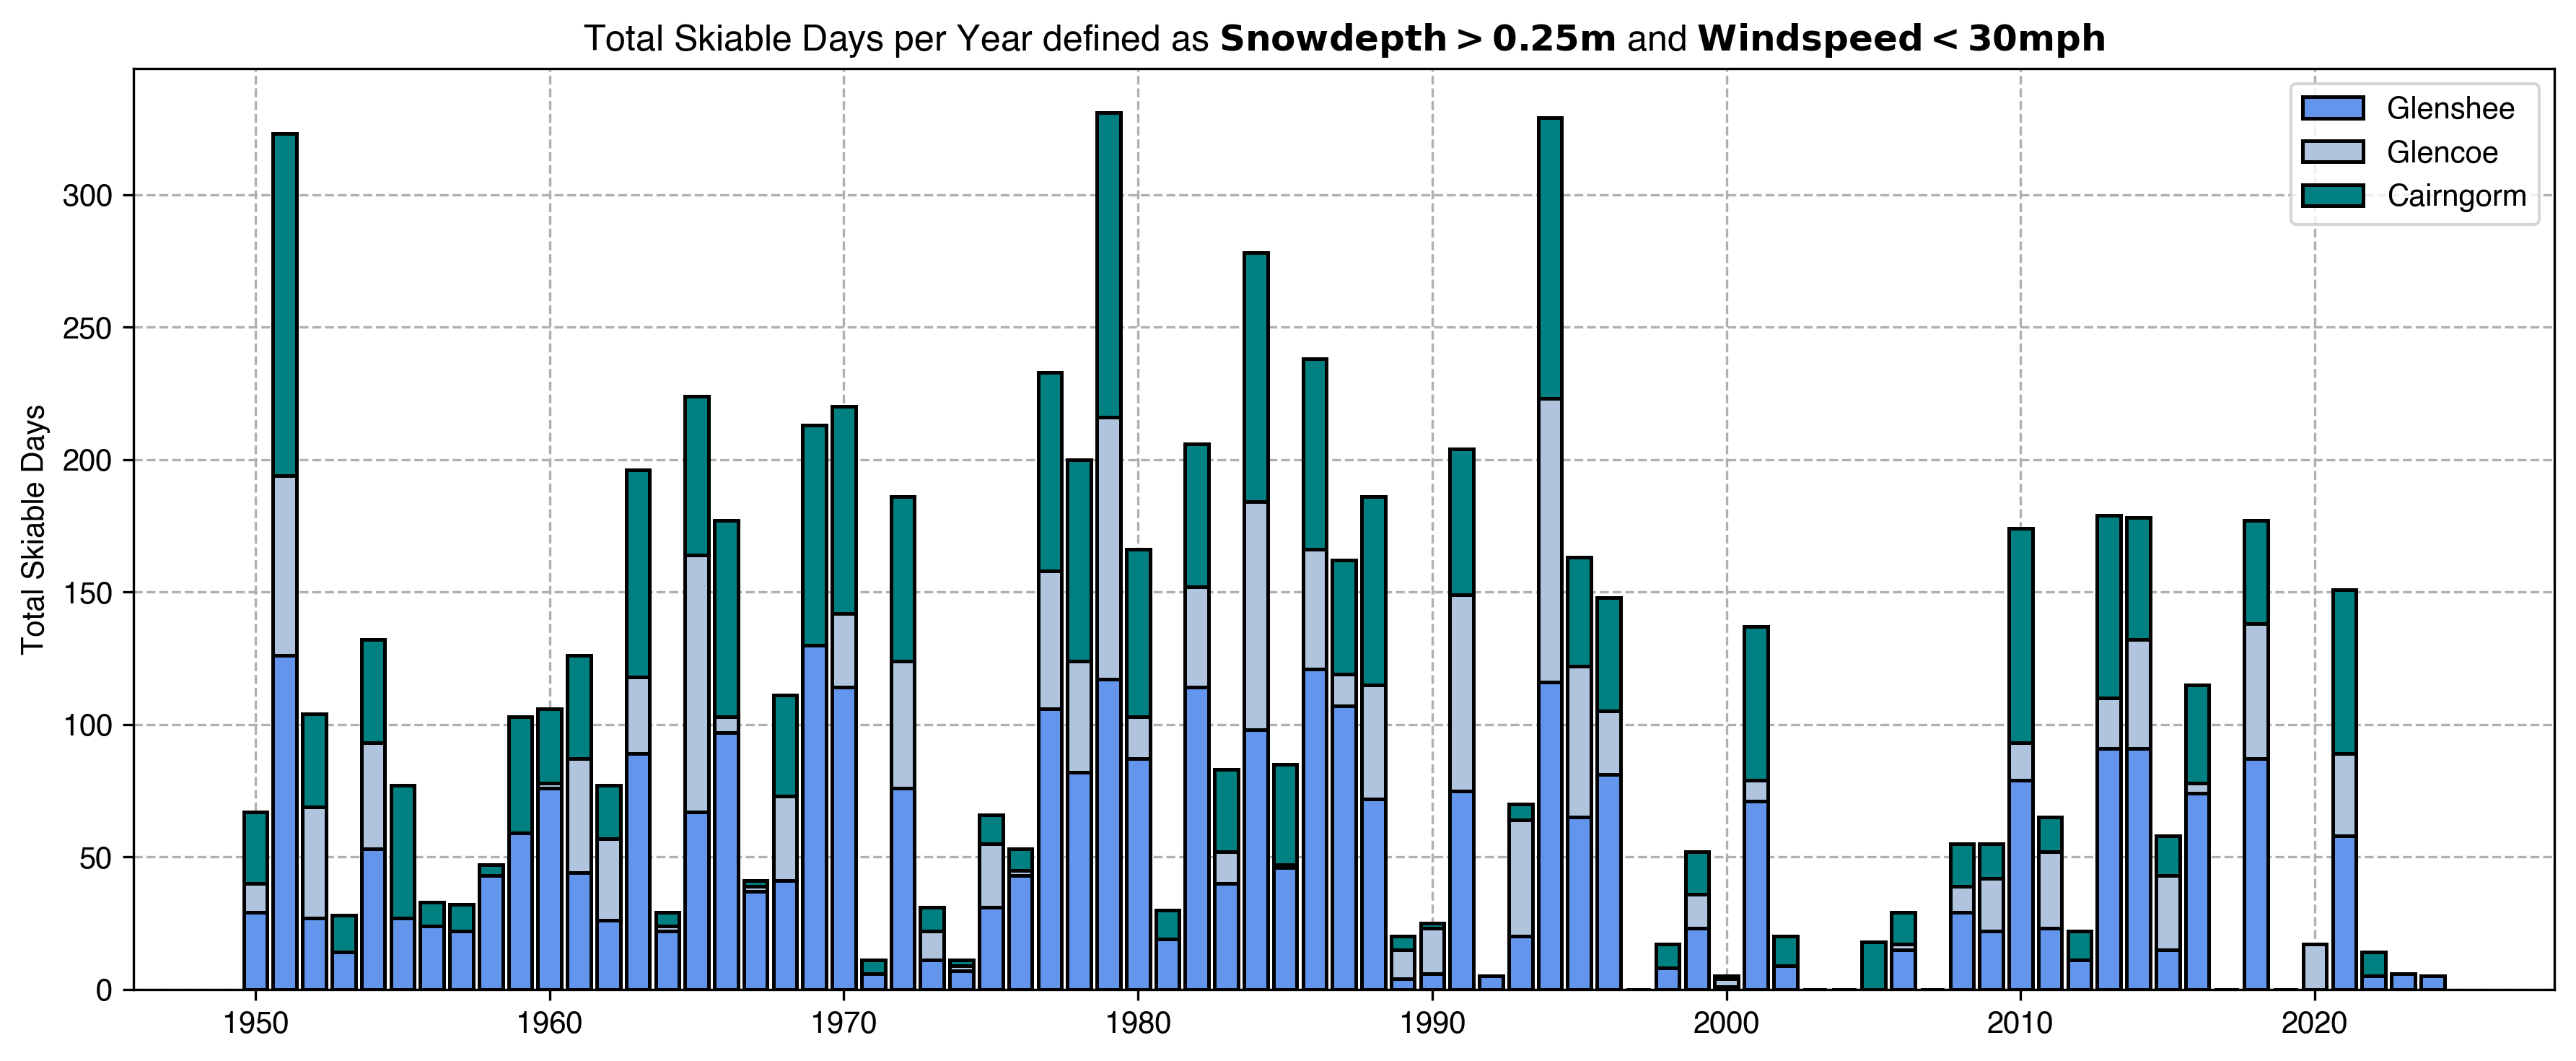

In [6]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
colors = ['cornflowerblue', 'lightsteelblue', 'teal']
bottom = np.zeros(len(skiable_data[list(skiable_data.keys())[0]]))
for i, (name, data) in enumerate(skiable_data.items()):
    ax.bar(data.index.year, data, bottom=bottom, color=colors[i], label=f'{name}', edgecolor='black', linewidth=1.2, zorder=2)
    bottom += data.values

ax.set_ylabel('Total Skiable Days')
ax.legend()
ax.grid(True, linestyle='--', zorder=-4)
ax.set_title(r'Total Skiable Days per Year defined as $\bf{Snowdepth > 0.25m}$ and $\bf{Windspeed < 30mph}$')
plt.tight_layout()
plt.savefig('./output/skiable_days.png')
plt.show()

In [ ]:
# write script to fetch ee imagecollection and caluclate skiable days as a spatial dataset and plot as a map
# write script to fetch ee imagecollection and calculate anomalies as a spatial dataset and plot as a map


In [8]:
import ee
import geemap

# Initialize the Earth Engine module
ee.Initialize()

def fetch_and_process_era5(lat_range, lon_range, start_date, end_date):
    # Define the geographic domain
    area = ee.Geometry.Rectangle([lon_range[0], lat_range[0], lon_range[1], lat_range[1]])
    
    # Load ERA5 daily dataset
    era5_daily = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate(start_date, end_date) \
        .filterBounds(area)
    
    # Define the conditions for skiable days
    wind_speed_threshold_mps = 50 / 2.23694  # Convert mph to m/s
    snow_depth_threshold_m = 0.25

    # Map function to check both conditions
    def check_conditions(image):
        # Calculate resultant wind speed
        u_wind = image.select('u_component_of_wind_10m')
        v_wind = image.select('v_component_of_wind_10m')
        resultant_wind_speed = u_wind.pow(2).add(v_wind.pow(2)).sqrt()

        # Check wind and snow conditions
        suitable_wind = resultant_wind_speed.lt(wind_speed_threshold_mps)
        suitable_snow = image.select('snow_depth').gt(snow_depth_threshold_m)
        
        # Return image with combined conditions
        return suitable_wind.And(suitable_snow).rename('skiable_day')

    # Apply the map function
    skiable_days = era5_daily.map(check_conditions)
    
    # Sum the skiable days
    total_skiable_days = skiable_days.sum().rename('total_skiable_days')
    
    return total_skiable_days, area

def plot_skiable_days(skiable_days, area):
    # Use geemap to visualize the results
    Map = geemap.Map(center=(56.4907, -4.2026), zoom=7)
    Map.addLayer(skiable_days, {'min': 0, 'max': 30, 'palette': ['blue', 'limegreen', 'yellow', 'orange', 'red']}, 'Total Skiable Days')
    Map.addLayerControl()
    Map.centerObject(area, 8)
    return Map

# Define parameters
lat_range = [55, 59]
lon_range = [-8, -1]
start_date = '1950-01-01'
end_date = '1955-12-31'

# Fetch and process data
total_skiable_days, area = fetch_and_process_era5(lat_range, lon_range, start_date, end_date)

# Plot the results
plot_skiable_days(total_skiable_days, area)


Map(center=[57.012923049620966, -4.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

In [12]:
import ee
import xee
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xee
import cartopy.feature


# Initialize the Earth Engine module
ee.Initialize()

def fetch_and_process_era5(start_date, end_date, country_name='United Kingdom'):
    # Load the country boundaries
    countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    country = countries.filter(ee.Filter.eq('country_na', country_name))

    # Define the geographic domain by the specific country boundary
    area = country.geometry()

    # Load ERA5 daily dataset and clip it to the country boundary
    era5_daily = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(area))
    
    # Define the conditions for skiable days
    wind_speed_threshold_mps = 50 / 2.23694  # Convert mph to m/s
    snow_depth_threshold_m = 0.25

    # Map function to check both conditions
    def check_conditions(image):
        # Calculate resultant wind speed
        u_wind = image.select('u_component_of_wind_10m')
        v_wind = image.select('v_component_of_wind_10m')
        resultant_wind_speed = u_wind.pow(2).add(v_wind.pow(2)).sqrt()

        # Check wind and snow conditions
        suitable_wind = resultant_wind_speed.lt(wind_speed_threshold_mps)
        suitable_snow = image.select('snow_depth').gt(snow_depth_threshold_m)
        
        # Return image with combined conditions
        return suitable_wind.And(suitable_snow).rename('skiable_day')

    # Apply the map function
    skiable_days = era5_daily.map(check_conditions)
    
    # Sum the skiable days
    total_skiable_days = skiable_days.sum().rename('total_skiable_days')
    
    # Convert to xarray Dataset
    ds = xee.Image(total_skiable_days).sampleRectangle(region=area, defaultValue=np.nan).to_xarray()
    
    return ds

def plot_skiable_days_xarray(ds):
    # Plot using Matplotlib and Cartopy
    fig, ax = plt.subplots(figsize=(10, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-10, 2, 50, 60], crs=ccrs.PlateCarree())
    
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.coastlines(resolution='10m')
    
    # Plot the data
    im = ax.imshow(ds.skiable_day.values, extent=[-10, 2, 50, 60], transform=ccrs.PlateCarree(), cmap='viridis', origin='upper')
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
    cbar.set_label('Total Skiable Days')
    
    plt.title('Skiable Days in the UK (1950-1955)')
    plt.show()

# Define parameters
start_date = '1950-01-01'
end_date = '1955-12-31'

# Fetch and process data
ds = fetch_and_process_era5(start_date, end_date, 'United Kingdom')

# Plot the results
plot_skiable_days_xarray(ds)


ModuleNotFoundError: No module named 'xee'